<a href="https://colab.research.google.com/github/vavaqwe/Vitalya/blob/main/vitalya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt  # бібліотека для побудови графіків
import numpy as np  # бібліотека для роботи з масивами та матрицями
import PIL  # бібліотекв для роботи з зображеннями
import tensorflow as tf  # бібліотека для машинного навчання та глибокого навчання

from tensorflow import keras  # модуль keras з бібліотеки TensorFlow
from tensorflow.keras import layers  # модуль layers з бібліотеки keras
from tensorflow.keras.models import Sequential  # Імпорт класу Sequential для створення послідовних моделей
from PIL import Image  # Імпорт класу Image для роботи з зображеннями


In [ ]:
import pathlib  # бібліотека для роботи з шляхами

# Створення об'єкту шляху до каталогу '/content/drive/MyDrive/anime_characters'
# Методом with_suffix('') вказуємо, що не потрібно змінювати розширення файлу (якщо воно було вказано)
dataset_dir = pathlib.Path('/content/drive/MyDrive/anime_characters').with_suffix('')
print(dataset_dir)  # Вивід шляху до каталогу

/content/drive/MyDrive/anime_characters


In [ ]:
image_count = len(list(dataset_dir.glob("*/*.jpeg")))
# Отримання списку файлів з розширенням '.jpeg'
# та підрахунок їх кількості за допомогою функції len()

print(f"Всего изображений: {image_count}")  # Вивід загальної кількості зображень


Всего изображений: 1210


In [ ]:
batch_size = 32  # Розмір пакету даних для навчання

img_width = 128  # Ширина зображень
img_height = 128  # Висота зображень

# Створення набору даних для тренування з використанням image_dataset_from_directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,  # Розділ даних на тренувальний та валідаційний набори в співвідношенні 80/20
    subset="training",  # Використання підмножини для тренування
    seed=123,  # Встановлення випадкового насіння для відтворюваності результатів
    image_size=(img_height, img_width),  # Розміри зображень
    batch_size=batch_size  # Розмір пакету даних
)

# Створення набору даних для валідації з аналогічними параметрами
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",  # Використання підмножини для валідації
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names  # Отримання назв класів
print(f"Class names: {class_names}")

# Кешування, перемішування та попереднє завантаження даних для ефективного використання пам'яті та швидкості навчання
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 1210 files belonging to 15 classes.
Using 968 files for training.
Found 1210 files belonging to 15 classes.
Using 242 files for validation.
Class names: ['Elric Edward', 'Eren Yeager', 'Goku', 'Gon', 'Ichigo', 'Killua', 'Lelouch Lamperouge', 'Light Yagami', 'Luffy', 'Naruto', 'Natsu Dragneel', 'Sakata Gintoki', 'Sasuke', 'Vegeta', 'Zoro']


In [ ]:
num_classes = len(class_names)  # Кількість унікальних класів у вашому наборі даних
print(num_classes)  # Виведення кількості класів

15


In [ ]:
# Створення моделі Sequential
model = Sequential([
    # Перетворення зображення: рескалінг та аугментація
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.2),


		layers.experimental.preprocessing.CenterCrop(img_height, img_width),
    layers.experimental.preprocessing.RandomContrast(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
		# це обробка фото перед навчанням

    # Згорткові шари та шари максимального згортання
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'), # шари згортання  з функцією ативації relu
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Випадкове відключення (Dropout)
    layers.Dropout(0.2),

    # Згорткові шари для виведення в одномірний вектор
    layers.Flatten(),

    # Повнозв'язані шари з функцією активації ReLU
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

# Компіляція моделі
model.compile(
    optimizer='adam', # активація
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # функція втрат
    metrics=['accuracy'] # метрика якості
)

# Вивід інформації про модель
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 128, 128, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 128, 128, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 128, 128, 3)       0         
                                                                 
 random_contrast (RandomCon  (None, 128, 128, 3)       0         
 trast)                                                          
                                                                 
 center_crop (CenterCrop)    (None, 128, 128, 3)       0

Epoch 1/20
31/31 [==============================] - 184s 1s/step - loss: 2.5734 - accuracy: 0.1488 - val_loss: 2.4312 - val_accuracy: 0.1901
Epoch 2/20
31/31 [==============================] - 1s 21ms/step - loss: 2.2853 - accuracy: 0.2541 - val_loss: 2.0967 - val_accuracy: 0.3140
Epoch 3/20
31/31 [==============================] - 1s 18ms/step - loss: 2.0604 - accuracy: 0.3502 - val_loss: 2.0240 - val_accuracy: 0.3636
Epoch 4/20
31/31 [==============================] - 1s 19ms/step - loss: 1.8545 - accuracy: 0.4132 - val_loss: 1.8635 - val_accuracy: 0.3843
Epoch 5/20
31/31 [==============================] - 1s 18ms/step - loss: 1.7517 - accuracy: 0.4597 - val_loss: 1.7743 - val_accuracy: 0.4339
Epoch 6/20
31/31 [==============================] - 1s 18ms/step - loss: 1.6084 - accuracy: 0.5041 - val_loss: 2.0854 - val_accuracy: 0.3719
Epoch 7/20
31/31 [==============================] - 1s 19ms/step - loss: 1.5134 - accuracy: 0.5207 - val_loss: 1.7189 - val_accuracy: 0.4752
Epoch 8/20
31

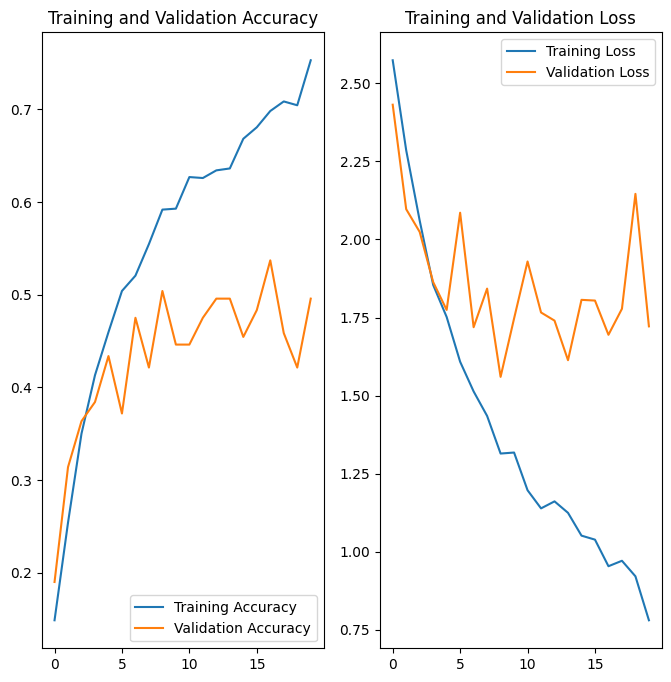

In [ ]:
# Тренування моделі
epochs = 20  # Кількість епох тренування
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

# Визначення точності, втрат, точності на валідації та втрат на валідації для кожної епохи
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)  # Діапазон епох для відображення на графіку

# Візуалізація результатів тренування та валідації
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')


plt.show()  # Відображення графіків

1/1 [==============================] - 0s 380ms/step
На зображенні скоріш за все Natsu Dragneel (50.13% вірогідність)


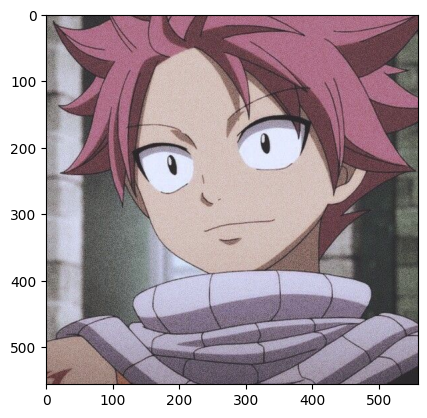

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_width = 128  # Ширина зображень
img_height = 128
image_path = '/content/drive/MyDrive/ші/natsu.jpg'

img_show = mpimg.imread(image_path)
imgplot = plt.imshow(img_show)

# Загрузка зображення за допомоги PIL
img = Image.open(image_path)
img = img.resize((img_width, img_height))  # задаемо розмір зображень

# перероблюємо зображення в матрицю
img_array = np.array(img)
img_array = tf.expand_dims(img_array, 0)

# використовуваня моделі для предикту
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Выведите результат предсказания
class_names = ['Elric Edward', 'Eren Yeager', 'Goku', 'Gon', 'Ichigo', 'Killua',
               'Lelouch Lamperouge', 'Light Yagami', 'Luffy', 'Naruto', 'Natsu Dragneel',
               'Sakata Gintoki', 'Sasuke', 'Vegeta', 'Zoro']
print("На зображенні скоріш за все {} ({:.2f}% вірогідність)".format(
    class_names[np.argmax(score)],
    100 * np.max(score)
))

# виводимо зображення
plt.show()


In [ ]:
from google.colab import files  # Імпорт бібліотеки для роботи з файлами в середовищі Google Colab

# Шлях та ім'я файлу для збереження моделі
model_file_name = "/content/drive/MyDrive/ші/my_anime_model.h5"

# Збереження моделі у форматі HDF5
model.save(model_file_name)

# Завантаження моделі на локальний комп'ютер користувача
files.download(model_file_name)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 203ms/step
На изображении скорее всего Luffy (98.98% вероятность)
8


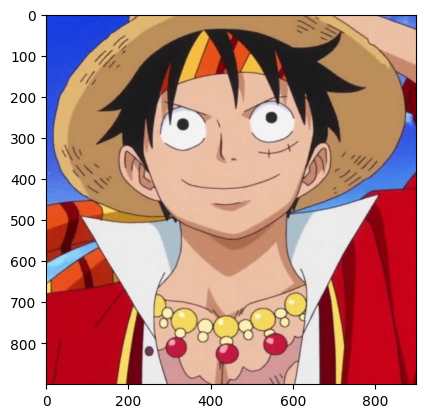

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

img_width = 128  # Ширина зображень
img_height = 128
image_path = '/content/drive/MyDrive/ші/luffy.jpg'

img_show = mpimg.imread(image_path)
imgplot = plt.imshow(img_show)

# посилання на модель https://drive.google.com/file/d/1TMn1u81cBsT_-EQs2oSKmmTL2gs93NZ8/view?usp=sharing
# Загрузите модель из файла H5
model_path = '/content/drive/MyDrive/ші/my_anime_model.h5'
model = tf.keras.models.load_model(model_path)

# Загрузите изображение с помощью PIL
img = Image.open(image_path)
img = img.resize((img_width, img_height))  # Подгон размера

# Преобразуйте изображение в массив numpy
img_array = np.array(img)
img_array = tf.expand_dims(img_array, 0)

# Произведите предсказания
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Выведите результат предсказания
class_names = ['Elric Edward', 'Eren Yeager', 'Goku', 'Gon', 'Ichigo', 'Killua',
               'Lelouch Lamperouge', 'Light Yagami', 'Luffy', 'Naruto', 'Natsu Dragneel',
               'Sakata Gintoki', 'Sasuke', 'Vegeta', 'Zoro']
print("На изображении скорее всего {} ({:.2f}% вероятность)".format(
    class_names[np.argmax(score)],
    100 * np.max(score)
))
print(np.argmax(score))

# Отобразите само изображение
plt.show()